## Import libraries

In [27]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


## Load data

In [28]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [29]:
train.shape, test.shape

((891, 12), (418, 11))

In [30]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Overview
* Target variable: Survived. 
* Categorical Variables: Pclass, Sex, Age, Cabin, Embarked
* Continuous Variables: Fare, SibSp, Parch
* PassengerId, Name, Ticket are useless for analysis

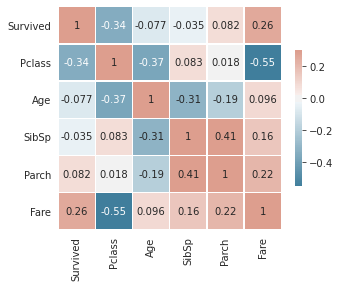

In [36]:
# Correlation matrix Heat map plot 
corr = train.drop(['PassengerId', 'Name'], axis=1).corr()
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

* Survived correleates with both Fare and Pclass
* Fare and Pclass are correlated (Both indicates social-economic level of the passenger)

### Survived
* Indicates if the passenger survived to the shipwreck or not. 
* Target variable. This is what we want to predict. 


In [33]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Pclass
* Ticket class with the passenger is traveling
* Three categories: 1st class (wealthier), 2nd class, 3rd class (poorer)
* Wealthier people has more survival probability?

In [34]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

#### vs Survived

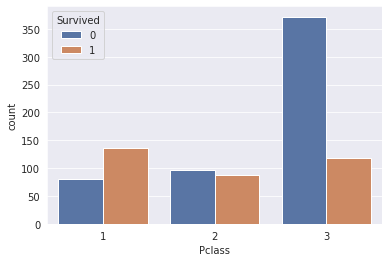

In [38]:
sns.countplot('Pclass', hue='Survived', data=train);

* People with 3rd class ticket tends to dies quite more that other ticket classes
* This seems a relevant variable for the model

### Age

* Age of the passenger
* We know about "children and women first" rescue protocol, so younger passenger should survive more than older ones.

In [48]:
train['Age'].isna().sum()

177

* There are 177 missing values for age. We could infer it from other variables afterwards

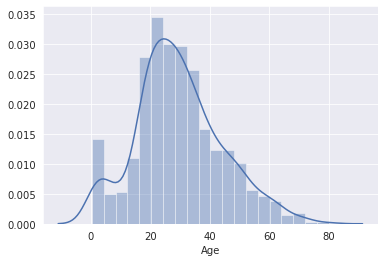

In [47]:
# Histogram
sns.distplot(train['Age']);

#### vs Survived

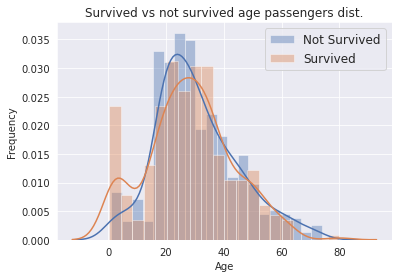

In [49]:
sns.distplot(train[train['Survived'] == 0].Age, bins=20, label='Not Survived')
sns.distplot(train[train['Survived'] == 1].Age, bins=20, label='Survived')

plt.legend(prop={'size': 12})
plt.title('Survived vs not survived age passengers dist.')
plt.xlabel('Age')
plt.ylabel('Frequency');

* Both dist are quite similar except we can observ children (0-10 years old aprox.) have higher survive probability. As we had expected because of children and women first protocol.
* Middle-age people (20-30 years old) seems the most likely to die.

### Cabin

In [56]:
train['Cabin'].isna().sum(), train.shape

(687, (891, 12))

* Most of the Cabin values are missing (around 77%), we are going to ignore this variable for now

### Embarked 
* City the passenger has embarked
* Three categories: C = Cherbourg, Q = Queenstown, S = Southampton

In [59]:
train['Embarked'].isna().sum()

2

* There are just two missing values. We could assign the city from which more passengers embark (which is Southampton)

In [68]:
embarked_mode = train['Embarked'].mode()[0]
train['Embarked'].fillna(embarked_mode, inplace=True)

In [69]:
train['Embarked'].isna().sum()

0

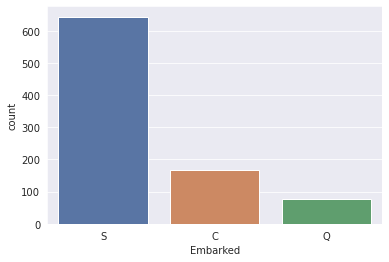

In [58]:
sns.countplot('Embarked', data=train);

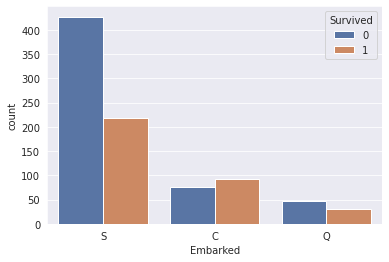

In [71]:
sns.countplot('Embarked', hue='Survived', data=train);

* Survival rate is around 50% in both Cherbourg and Queenstown, but most of people coming from Southampton died.

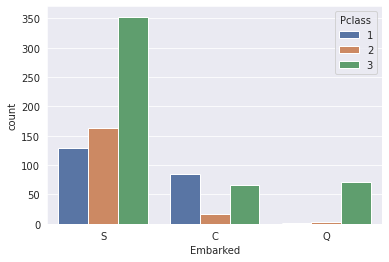

In [74]:
sns.countplot('Embarked', hue='Pclass', data=train);

* Low survivality ration could to come from the fact that there are many 3rd class passengers which embarked in Southampton

## Continuous variables
### Fare
* Ticket fare
* We can transform this variable in categorical by split fare values into bins.

In [75]:
train['Fare'].isna().sum()

0

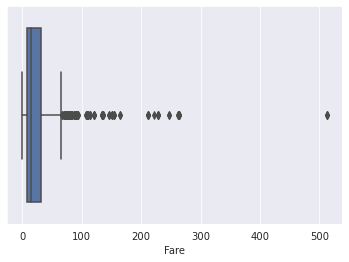

In [76]:
sns.boxplot(train['Fare']);

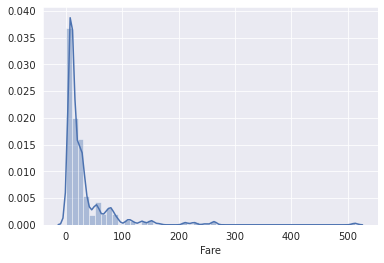

In [77]:
sns.distplot(train['Fare']);

* Fare has a very high skewness to the right.

#### vs Survived

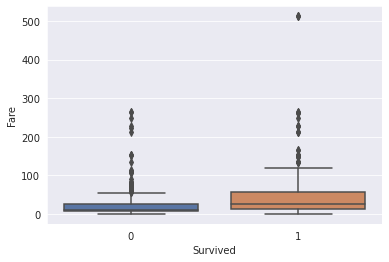

In [84]:
sns.boxplot('Survived', 'Fare', data=train);

* Passengers with high fare tickets tends to survive more than passengers with low ones

## Feature Engineering
### Title

* Some passengers has titles in their names. We'll extract from the 'Name' column and transform in a new categorical variable.

In [85]:
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [96]:
titles = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0])
titles.head()

0       Mr
1      Mrs
2     Miss
3      Mrs
4       Mr
Name: Name, dtype: object

In [93]:
titles.value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Major             2
 Mlle              2
 Col               2
 Jonkheer          1
 Mme               1
 the Countess      1
 Don               1
 Lady              1
 Capt              1
 Sir               1
 Ms                1
Name: Name, dtype: int64

In [113]:
# Title Categories: [Mr, Miss, Mrs, Master, Royalty, Officer]
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles(df):
    """ Extract Title passenger from Name column and assign into one title category """
    df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    df['Title'] = df['Title'].map(Title_Dictionary)
    return df

In [114]:
for df in [train, test]:
    get_titles(df)

In [118]:
train['Title']

0           Mr
1          Mrs
2         Miss
3          Mrs
4           Mr
        ...   
886    Officer
887       Miss
888       Miss
889         Mr
890         Mr
Name: Title, Length: 891, dtype: object

In [ ]:
train.columns

### Missing values: Age

* We are gonna impute age missing values from other variable. We need to look for variables that correleates with age.